In [1]:
# # Create Python package from Rust code
# maturin develop --release

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as fred_downloader

import pcmcirustpy

# Download economic variables from FRED

In [4]:
series = {
    # Monetary & financial
    "Interest_Rate": "FEDFUNDS",
    "Long_Term_Rate": "GS10",
    "Credit_Spread": "BAA10Y",

    # Prices & expectations
    "CPI": "CPIAUCSL",  # to compute YoY inflation
    "Inflation_Expectations": "MICH",
    "House_Prices": "USSTHPI",

    # Output & supply side
    "GDP": "GDPC1",
    "Industrial_Production": "INDPRO",
    "Productivity": "OPHNFB",
    "Capacity_Utilization": "TCU",
    "Employment": "PAYEMS",

    # External sector
    "Exports": "EXPGS",
    "Imports": "IMPGS",
    "Real_Exchange_Rate": "RBUSBIS",

    # Fiscal policy
    "Public_Debt_GDP_Ratio": "GFDEGDQ188S",
    "Govt_Expenditures": "FGEXPND",
    "Govt_Gross_Investment": "A782RC1Q027SBEA",
    "Private_Investment": "GPDIC1",

    # Prices & commodity cycle
    "Oil_Price": "POILWTIUSDM",
    "Commodity_Index": "PALLFNFINDEXQ",

    # Sentiment
    "Consumer_Confidence": "UMCSENT",
}

In [5]:
start = "1980-01-01"
end = "2024-12-31"

df = pd.DataFrame()
for name, code in series.items():
    if code:
        try:
            df[name] = fred_downloader.DataReader(code, "fred", start, end)[code]
        except Exception as e:
            print(f"Error loading {name}: {e}")

### Variables have different frequencies: resample to least granular frequency (quarterly)

In [6]:
df_q = df.resample("QE").mean()

### Feature engineering

In [7]:
df_q["GDP_Growth"] = df_q["GDP"].pct_change(4) * 100
df_q["Productivity_Growth"] = np.log(df_q["Productivity"]).diff() * 100
df_q["Employment_Growth"] = df_q["Employment"].pct_change() * 100
df_q["Capacity_Utilization"] = df_q["Capacity_Utilization"]

df_q["Inflation_Rate"] = df_q["CPI"].pct_change(4) * 100

df_q["Oil_Price_Growth"] = np.log(df_q["Oil_Price"]).diff() * 100
df_q["Commodity_Index_Growth"] = np.log(df_q["Commodity_Index"]).diff() * 100

df_q["Exports_Growth"] = df_q["Exports"].pct_change(1) * 100
df_q["Imports_Growth"] = df_q["Imports"].pct_change(1) * 100
df_q["Real_Exchange_Rate_Growth"] = np.log(df_q["Real_Exchange_Rate"]).diff() * 100

df_q["Govt_Expenditures_Growth"] = df_q["Govt_Expenditures"].pct_change() * 100
df_q["Govt_Gross_Investment_Growth"] = df_q["Govt_Gross_Investment"].pct_change() * 100
df_q["Private_Investment_Growth"] = df_q["Private_Investment"].pct_change() * 100
df_q["Public_Debt_GDP_Change"] = df_q["Public_Debt_GDP_Ratio"].diff()

df_q["Yield_Curve_Slope"] = df_q["Long_Term_Rate"] - df_q["Interest_Rate"]
df_q["Interest_Rate"] = df_q["Interest_Rate"]
df_q["Credit_Spread"] = df_q["Credit_Spread"]

df_q["Consumer_Confidence"] = df_q["Consumer_Confidence"]
df_q["House_Prices_Growth"] = np.log(df_q["House_Prices"]).diff() * 100

In [8]:
# Drop raw levels
df_q = df_q.drop(columns=[
    "CPI", "GDP", "Productivity", "Employment",
    "Oil_Price", "Commodity_Index",
    "Exports", "Imports",
    "Govt_Expenditures", "Govt_Gross_Investment",
    "Private_Investment", "Public_Debt_GDP_Ratio",
    "Real_Exchange_Rate",
    "Long_Term_Rate", "House_Prices"
], errors='ignore')

In [9]:
df_q = df_q.sort_index()  # sort by date
df_q = df_q.dropna()

In [10]:
# Standardize (optional but helps)
df_q = (df_q - df_q.mean()) / df_q.std()

### Final data

In [11]:
df_q.columns.tolist()

['Interest_Rate',
 'Credit_Spread',
 'Inflation_Expectations',
 'Industrial_Production',
 'Capacity_Utilization',
 'Consumer_Confidence',
 'GDP_Growth',
 'Productivity_Growth',
 'Employment_Growth',
 'Inflation_Rate',
 'Oil_Price_Growth',
 'Commodity_Index_Growth',
 'Exports_Growth',
 'Imports_Growth',
 'Real_Exchange_Rate_Growth',
 'Govt_Expenditures_Growth',
 'Govt_Gross_Investment_Growth',
 'Private_Investment_Growth',
 'Public_Debt_GDP_Change',
 'Yield_Curve_Slope',
 'House_Prices_Growth']

In [12]:
df_q.shape

(83, 21)

In [13]:
df_q.head()

,Interest_Rate,Credit_Spread,Inflation_Expectations,Industrial_Production,Capacity_Utilization,Consumer_Confidence,GDP_Growth,Productivity_Growth,Employment_Growth,Inflation_Rate,...,Commodity_Index_Growth,Exports_Growth,Imports_Growth,Real_Exchange_Rate_Growth,Govt_Expenditures_Growth,Govt_Gross_Investment_Growth,Private_Investment_Growth,Public_Debt_GDP_Change,Yield_Curve_Slope,House_Prices_Growth
DATE,,,,,,,,,,,,,,,,,,,,,
2003-06-30,-0.244528,0.692200,-1.463438,-1.739423,-0.628836,0.662096,-0.150240,1.068518,-0.288301,-0.357004,...,-0.871220,-0.335861,-0.402741,-1.477078,0.171195,-0.626437,-0.086927,0.136822,0.782219,0.100767
2003-09-30,-0.365934,0.395032,-1.226109,-1.604945,-0.442628,0.664793,0.436895,2.156475,-0.164221,-0.241187,...,-0.003777,0.282119,0.073847,0.173897,-0.122541,0.978959,0.722397,-0.304817,1.419324,0.282222
2003-12-31,-0.376491,0.018135,-0.798915,-1.408767,-0.188484,0.880499,0.928895,0.597684,-0.014511,-0.359259,...,0.581930,0.816190,0.518437,-1.601729,-0.022857,-0.277874,0.666967,0.032983,1.474724,1.009247
2004-03-31,-0.372972,-0.315274,-0.656517,-1.263368,0.003167,1.368536,0.947995,-0.949974,0.033330,-0.460275,...,0.689252,0.489186,0.851104,-0.841662,-0.015793,-0.514725,-0.218182,-0.099371,1.268232,0.301105
2004-06-30,-0.369453,-0.373258,0.102938,-1.145906,0.162720,0.991049,0.895330,0.728623,0.198468,0.071211,...,0.478536,0.342046,0.843199,1.282676,-0.086244,0.622139,0.821283,-0.134116,1.701362,0.794655


# Run PCMCI algorithm and uncover causal relationships

In [28]:
result = pcmcirustpy.run_pcmci(
    df_q.values,
    max_lag=4,
    alpha=0.05,
    max_condition_set_size=3,
    max_subsets=1
)

print("P-matrix:")
print(result["p_matrix"])

print("\nEffect size matrix:")
print(result["val_matrix"])

P-matrix:
[[[           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  ...
  [           nan            nan            nan            nan
              nan]
  [           nan 2.41571207e-11            nan            nan
   1.11944220e-04]
  [           nan            nan            nan            nan
   1.78869312e-06]]

 [[           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  ...
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  [           nan 7.81536278e-03            nan            nan
           

In [29]:
series = dict(zip(df_q.columns, df_q.columns))

for val in np.argwhere(~np.isnan(result["val_matrix"])):
    if result['p_matrix'][val[0], val[1], val[2]] < 0.05:
        print(
            f"{list(series.keys())[val[0]]} -> {list(series.keys())[val[1]]} at lag {val[2]}: "
            f"Effect size = {result['val_matrix'][val[0], val[1], val[2]]}, "
            f"P-value = {result['p_matrix'][val[0], val[1], val[2]]}"
        )

Interest_Rate -> Yield_Curve_Slope at lag 1: Effect size = -0.6916574875766609, P-value = 2.4157120748213856e-11
Interest_Rate -> Yield_Curve_Slope at lag 4: Effect size = 0.4286432815975269, P-value = 0.00011194421960003531
Interest_Rate -> House_Prices_Growth at lag 4: Effect size = -0.5105919476798771, P-value = 1.7886931236166248e-06
Credit_Spread -> Industrial_Production at lag 1: Effect size = -0.323248450016494, P-value = 0.0046728315531963105
Credit_Spread -> Capacity_Utilization at lag 1: Effect size = -0.6617454733843093, P-value = 1.0208212053441912e-10
Credit_Spread -> GDP_Growth at lag 1: Effect size = -0.4268849347454831, P-value = 0.0002542938645728743
Credit_Spread -> Govt_Gross_Investment_Growth at lag 3: Effect size = -0.5071558650584965, P-value = 2.1532770995147388e-06
Credit_Spread -> House_Prices_Growth at lag 1: Effect size = -0.30293190723568386, P-value = 0.007815362775037693
Inflation_Expectations -> Consumer_Confidence at lag 1: Effect size = -0.3646188960621

# Additional analysis: Use causally relevant variables as exogenous variables to improve ARIMA forecast

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [39]:
df_arima = df_q.copy()
target = "GDP_Growth"

### Compare ARIMA vs ARIMAX with causally relevant variables vs ARIMAX with all variables

In [ ]:
# Add the correct lags as per PCMCI results
def add_lags(df, var, lags):
    for lag in lags:
        df[f"{var}_lag{lag}"] = df[var].shift(lag)
    return df

df_arima = add_lags(df_arima, "Capacity_Utilization", [4])
df_arima = add_lags(df_arima, "Employment_Growth", [2])
df_arima = add_lags(df_arima, "House_Prices_Growth", [1])

pcmci_lagged = [
    "Capacity_Utilization_lag4",
    "Employment_Growth_lag2",
    "House_Prices_Growth_lag1"
]

In [41]:
# For all-variables-ARIMAX model, add 1 lag for simplicity
all_drivers = [col for col in df_arima.columns if col != target]
for var in all_drivers:
    df_arima[f"{var}_lag1"] = df_arima[var].shift(1)
all_lagged = [col for col in df_arima.columns if "_lag" in col]

In [42]:
# Train-test split
df_arima.dropna(inplace=True)
train_size = int(len(df_arima) * 0.8)
train, test = df_arima.iloc[:train_size], df_arima.iloc[train_size:]

### Basic ARIMA model

In [ ]:
model_arima = ARIMA(train[target], order=(1, 0, 0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=len(test))

### ARIMAX with causally relevant variables at lags specified by PCMCI outputs

In [ ]:
model_pcmci = ARIMA(
    train[target],
    exog=train[pcmci_lagged],
    order=(1, 0, 0)
)
fit_pcmci = model_pcmci.fit()
pred_pcmci = fit_pcmci.forecast(steps=len(test), exog=test[pcmci_lagged])

### ARIMAX with all variables as exogenous variables

In [ ]:
model_all = ARIMA(
    train[target],
    exog=train[all_lagged],
    order=(1, 0, 0)
)
fit_all = model_all.fit()
pred_all = fit_all.forecast(steps=len(test), exog=test[all_lagged])

### Compare results

In [46]:
rmse_arima = np.sqrt(mean_squared_error(test[target], pred_arima))
rmse_pcmci = np.sqrt(mean_squared_error(test[target], pred_pcmci))
rmse_all = np.sqrt(mean_squared_error(test[target], pred_all))

print(f"ARIMA RMSE: {rmse_arima:.4f}")
print(f"PCMCI-ARIMAX RMSE: {rmse_pcmci:.4f}")
print(f"ALL-ARIMAX RMSE: {rmse_all:.4f}")

ARIMA RMSE: 1.5445
PCMCI-ARIMAX RMSE: 0.9902
ALL-ARIMAX RMSE: 1.5525


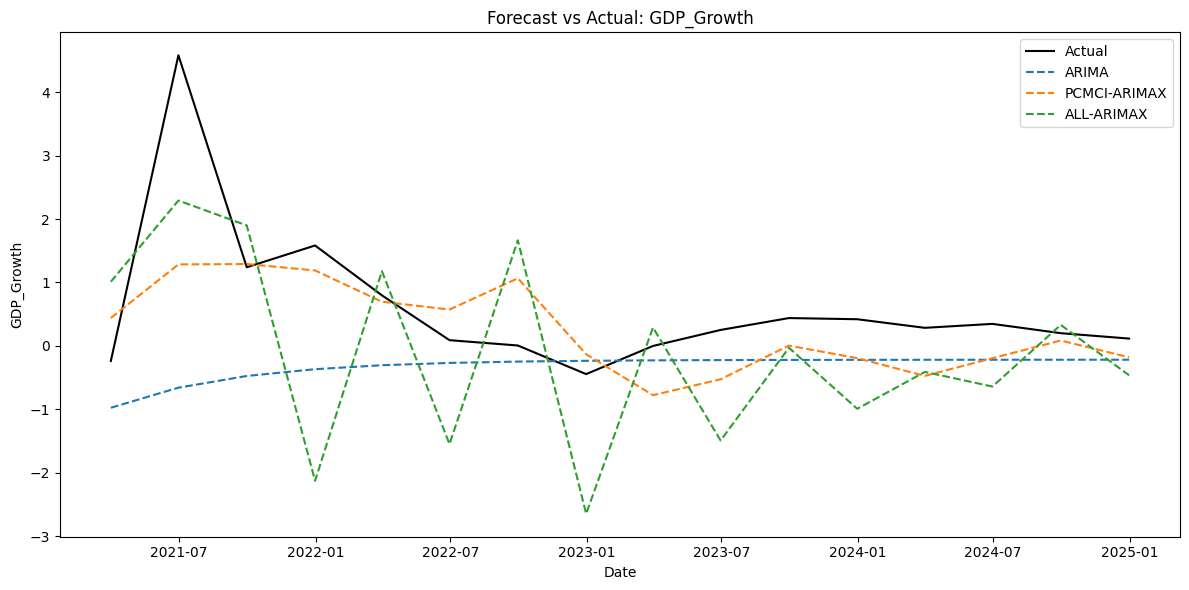

In [47]:
plt.figure(figsize=(12, 6))

# Actual
plt.plot(test.index, test[target], label="Actual", color="black")

# Baseline ARIMA
plt.plot(test.index, pred_arima, label="ARIMA", linestyle="--")

# PCMCI-ARIMAX
plt.plot(test.index, pred_pcmci, label="PCMCI-ARIMAX", linestyle="--")

# ALL-ARIMAX
plt.plot(test.index, pred_all, label="ALL-ARIMAX", linestyle="--")

plt.title(f"Forecast vs Actual: {target}")
plt.xlabel("Date")
plt.ylabel(f"{target}")
plt.legend()
plt.tight_layout()
plt.show()